# Montbrió–Pazó–Roxin (MPR) SDE — Simulation & Likelihood-Free Inference<br>
Minimal example using Numba-accelerated `MPR_sde` from `vbi`.<br>
Sections are short and documented so you can convert to a notebook easily.<br>
External APIs remain unchanged; only our helper functions are refactored.

<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/mpr_sde_numba_cde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install VBI package in Google Colab (lightweight, CPU-only version)
print("Setting up VBI for Google Colab...")

# Skip C++ compilation for faster installation in Colab
%env SKIP_CPP=1

# Install the package
!pip install vbi

print("VBI package installed successfully! Ready to proceed.")

Setting up VBI for Google Colab...
env: SKIP_CPP=1
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v4, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
  Using cached vbi-0.3-py3-none-any.whl
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic/numpy-2.3.3+computecanada-cp311-cp311-linux_x86_64.whl (from vbi)
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic/scipy-1.16.2+computecanada-cp311-cp311-linux_x86_64.whl (from vbi)
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic/numba-0.62.1+computecanada-cp311-cp311-linux_x86_64.whl (from vbi)
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3/h5py-3.15.0+computecanada-cp311-cp311-linux_x86_64.whl (from vbi)

#### Imports & Global Config

In [6]:
import os
import warnings
from copy import deepcopy
import multiprocessing as mp
from multiprocessing import Pool

In [7]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [8]:
import vbi
from vbi.models.numba.mpr import MPR_sde

In [9]:
warnings.simplefilter("ignore")
print(f"vbi version: {vbi.__version__}")

vbi version: 0.3


In [10]:
SEED = 42
np.random.seed(SEED)

In [11]:
LABELSIZE = 10
plt.rcParams["axes.labelsize"] = LABELSIZE
plt.rcParams["xtick.labelsize"] = LABELSIZE
plt.rcParams["ytick.labelsize"] = LABELSIZE

In [12]:
OUT_DIR = "output/mpr_sde_numba_cde_/"
os.makedirs(OUT_DIR, exist_ok=True)

If False: (re)generate data; if True: load from disk when available.

In [13]:
LOAD_DATA = True

#### Prior & Training Data Generation

In [48]:
data = np.load("sub-CC410097_theta_X_main.npz")  # replace with your file if different
theta = data["theta"]                 # shape: [2000, n_params]
X = data["X"]                         # shape: [2000, n_features]
theta = theta[:, None]  # shape becomes (2000, 1)

In [49]:
print (theta)
print (X)
print (theta.shape)
print (X.shape)

[[1.93881189]
 [1.89813531]
 [1.96321784]
 ...
 [2.0037317 ]
 [2.21508719]
 [2.21524989]]
[[0.21026527 6.63964366 0.11747612]
 [0.17077515 3.28460688 0.06129382]
 [0.30755688 5.96466188 0.06058207]
 ...
 [0.37582464 5.98196426 0.19464123]
 [0.0638693  1.88033464 0.10477043]
 [0.06404419 0.25106004 0.15037961]]
(2000, 1)
(2000, 3)


#### Train Density Estimator (MAF) & Posterior Summary

In [50]:
from vbi.utils import posterior_shrinkage_numpy, posterior_zscore_numpy
from vbi.cde import MAFEstimator
import autograd.numpy as anp

In [51]:
rng = anp.random.RandomState(SEED)
maf = MAFEstimator(n_flows=4, hidden_units=64)
maf.train(theta.astype(np.float32), X.astype(np.float32), n_iter=1000, learning_rate=2e-4)

Inferred dimensions: param_dim=1, feature_dim=3


Training:  26%|██▌       | 257/1000 [00:01<00:04, 162.51it/s, patience=20/20, train=0.9800, val=0.9367]


In [53]:
df = pd.read_csv("sub-CC410097_metrics.tsv", sep="\t")
print(df.head())

   FCD_VAR_OV_vect  homotopic_mean  FCD_diff  inter_fc_std
0         0.019794        0.349749  6.298247      0.066479


In [54]:
theta_true= 2.071
x_obs = np.array([[ 0.349749, 6.298247, 0.066479]], dtype=np.float32)

print(x_obs.shape)  # (1, 2)

(1, 3)


In [55]:
samples = maf.sample(x_obs, n_samples=5000, rng=rng)[0]
shrinkage = posterior_shrinkage_numpy(theta, samples)
zscore = posterior_zscore_numpy(2.099, samples)

In [56]:
print("True parameters:     ", theta_true)
print("MAF mean estimate:   ", np.mean(samples, axis=0))
print("Posterior shrinkage: ", np.array2string(shrinkage, precision=3, separator=", "))
print("Posterior z-score:   ", np.array2string(zscore, precision=3, separator=", "))

True parameters:      2.071
MAF mean estimate:    [1.917259]
Posterior shrinkage:  [0.539]
Posterior z-score:    [2.849]


In [57]:
np.savez(OUT_DIR + "samples.npz", samples=samples, xo=x_obs, theta_true= theta_true)

#### Feature–Parameter Scatter (Quick Diagnostic)

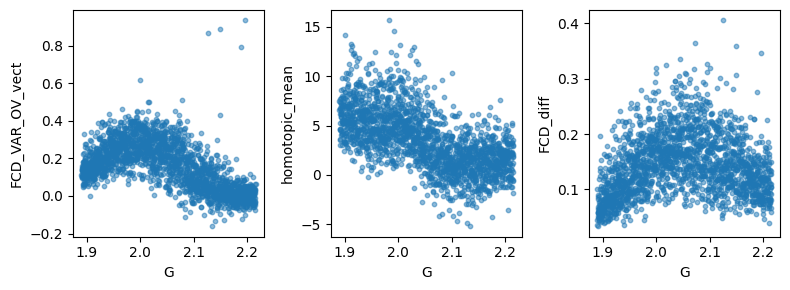

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].scatter(theta, X[:, 0], s=10, alpha=0.5)
ax[0].set_xlabel("G")
ax[0].set_ylabel("FCD_VAR_OV_vect")
ax[1].scatter(theta, X[:, 1], s=10, alpha=0.5)
ax[1].set_xlabel("G")
ax[1].set_ylabel("homotopic_mean")
ax[2].scatter(theta, X[:, 2], s=10, alpha=0.5)
ax[2].set_xlabel("G")
ax[2].set_ylabel("FCD_diff")
plt.tight_layout()

#### Posterior Plot (Pairplot)

In [59]:
from vbi.plot import pairplot_numpy
prior_min = [1.89]
prior_max = [2.21525]

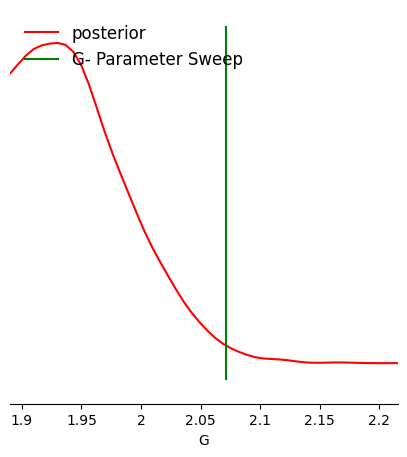

In [60]:
limits = [[lo, hi] for lo, hi in zip(prior_min, prior_max)]
fig, ax = pairplot_numpy(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=np.array([theta_true]).reshape(1, -1),
    labels=["G"],
    offdiag="kde",
    diag="kde",
    fig_kwargs=dict(points_offdiag=dict(marker="*", markersize=10), points_colors=["g"]),
    diag_kwargs={"mpl_kwargs": {"color": "r"}},
)
plt.legend(["posterior", "G- Parameter Sweep"], loc="upper left", fontsize=12, frameon=False)
fig.savefig(OUT_DIR + "/G.png", dpi=150)

In [46]:
from sbi import utils as sbi_utils
import torch

# Prior range for a single parameter
low = torch.tensor([1.89], dtype=torch.float32)
high = torch.tensor([2.21525], dtype=torch.float32)

prior = sbi_utils.BoxUniform(low=low, high=high)

In [47]:
from sbi.inference import SNPE

# Convert your simulation data
theta_tensor = torch.tensor(theta, dtype=torch.float32)  # shape (n_sim, 1)
X_tensor = torch.tensor(X, dtype=torch.float32)          # shape (n_sim, n_features)

# Create SNPE inference object
inference = SNPE(prior=prior)

# Train SNPE
density_estimator = inference.append_simulations(theta_tensor, X_tensor).train()

# Build posterior
posterior = inference.build_posterior(density_estimator)

# Use posterior for observed data
X_obs = torch.tensor(x_obs, dtype=torch.float32)
posterior_samples = posterior.sample((1000,), x=X_obs)

 Neural network successfully converged after 90 epochs.

1098it [00:00, 9713.42it/s]             


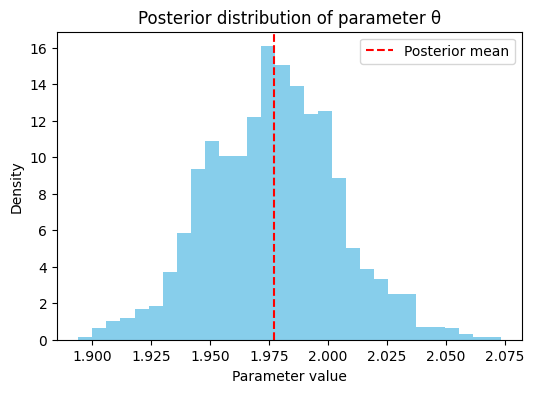

Posterior mean: 1.976994


In [52]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Convert posterior samples to numpy
samples = posterior_samples.numpy()  # shape (n_samples, n_parameters)

# Plot histogram for a single parameter
plt.figure(figsize=(6,4))
plt.hist(samples[:,0], bins=30, color='skyblue', density=True)
plt.title("Posterior distribution of parameter θ")
plt.xlabel("Parameter value")
plt.ylabel("Density")
plt.axvline(x=samples[:,0].mean(), color='red', linestyle='--', label='Posterior mean')
plt.legend()
plt.show()


posterior_mean = samples[:, 0].mean()
print("Posterior mean:", posterior_mean)